# Projet numérique III : câble sous-marin

#### Louis Blazejczak, Emmanuel Gardin

## Questions théoriques

#### 1.
La loi forte des grands nombres nous autorise à estimer l'espérance conditionnelle par la moyenne empirique de simulations conditionnelles. 

#### 2.

On considère le vecteur gaussien $Z_{1} = (Z(x_{j1}), Z(x_{j2}), ..., Z(x_{jn}))$ et le vecteur $Z_{2}$ des composantes de $Z$ qui ne sont pas connues. On réordonne $Z$ de manière à ce que les termes de $Z1$ soient les n derniers termes de Z.
On note $C$ la matrice de covariance définie positive de $Z$.
$C$ peut se décomposer en blocs :
\begin{align}
C  = 
\begin{pmatrix} 
C_{Z_{2}} & C_{Z_{2},Z_{1}} \\ C_{Z_{1},Z_{2}} & C_{Z_{1}}
\end{pmatrix}
\end{align}

La loi conditionnelle du vecteur des composantes de  $Z$ correspondant aux points de discrétisation sans observation connaissant les valeurs prises par les composantes aux sites d'observation s'écrit alors :


$f_{Z_{2}|Z_{1} = z_{1}}(z_{2}) = \frac{1}{(2 \pi)^{n/2} \sqrt{det(CS_{Z_{2}})}}exp\left(- \frac{1}{2}\left(z_{2}- \Psi(z_1)\right)^{t}CS_{Z_{2}}^{-1}\left(z_{2}- \Psi(z_1)\right)\right)$

où $CS_{Z_{2}}$ est le complément de Schur du bloc $C_{Z_{2}}$ : $CS_{Z_{2}} = C_{Z_{2}} - C_{Z_{2},Z_{1}}C_{Z_{1}}^{-1}C_{Z_{1},Z_{2}}$ et $\Psi$ est l'espérance conditionnelle du vecteur des sites sans observation $Z_{2}$ sachant $Z_{1}$

#### 3.

Soit $Y = (Y_{1}, ..., Y_{p})$ un vecteur de composantes gaussiennes indépendantes, toutes d'espérance nulle et de variance 1. $Z = m + RY$ où $R$ est une matrice $p \times p$ et $m$ est un vecteur de taille $p$.
Alors $Z$ est gaussien, comme combinaison linéaire de variables gaussiennes, $E(Z) = E(m + RY) = m$ et $V(Z) = E((RY)^{2}) = RI_{p}R^{T} = RR^{T}$. On note $C = RR^{t}$.

La loi $f_{Z}$ de $Z$ est alors :

\begin{equation}
f_{Z}(z) = \frac{1}{(2 \pi)^{p/2} \sqrt{det(C)}}exp(- \frac{1}{2}(z-m)^{t}C^{-1}(x-m))
\end{equation}

#### 4.

On souhaite simuler un vecteur gaussien $Z = (Z(x_{0}), ..., Z(x_{p}))$ à valeurs dans ${\rm I\!R}^p$, d'espérance $m$ et de matrice de covariance $C$ définie positive données. D'après la question précédente, on peut simuler un vecteur gaussien quelconque à partir d'un vecteur gaussien $Y$ de composantes indépendantes, d'espérances nulles et de variance 1 si on peut trouver une matrice $R$ telle que $C = R \times R^{T}$, car dans ce cas $Z$ a la même loi que $m + R \times Y$. 

Or, $C$ étant symétrique définie positive, il existe une matrice $R$ vérifiant cela (en effet, le théorème spectral permet de diagonaliser $C = P \Delta P^{T}$ en une matrice diagonale $\Delta$ à coefficients diagonaux strictement positifs, on pose alors $R = P \times \sqrt{\Delta}$ où $\sqrt{\Delta}$ est la matrice diagonale dont les coefficients sont les racines carrées des coefficients de $\Delta$). Il est donc possible de simuler $Z$ à partir de la simulation de $Y$.

L'algorithme de Cholesky permet de trouver une telle matrice $R$ qui est de plus triangulaire inférieure et qu'on appelle alors $L$ (pour Lower triangular matrix). Cet algorithme a l'avantage de ne pas avoir à connaître les valeurs propres de $C$.

### Algorithme de Cholesky :

Il s'agit d'un algorithme récursif qui débute avec $i = 1$ et $C^{(1)} = C$

A l'étape $i$, la matrice $C^{(i)}$ est de la forme suivante :
$C^{(i)}=
\begin{pmatrix}
\mathbf{I}_{i-1} & 0              & 0 \\
0                & a_{i,i}        & \mathbf{b}_{i}^{T} \\
0                & \mathbf{b}_{i} & \mathbf{B}^{(i)}
\end{pmatrix},
$
où $I_{i-1}$ représente la matrice identité de taille $i - 1$.

La matrice $L_{i}$ est définie par :

$L_{i}=
\begin{pmatrix}
I_{i-1} & 0                                  & 0 \\
0                & \sqrt{a_{i,i}}           & 0 \\
0                & \frac{1}{\sqrt{a_{i,i}}} \mathbf{b}_{i} & \mathbf{I}_{n-i}
\end{pmatrix},
$


donc $C^{(i)}$ s'écrit : 


$C^{(i)} = L_{i} C^{(i+1)} L_{i}^{T}$


où


$C^{(i+1)}=
\begin{pmatrix}
\mathbf{I}_{i-1} & 0 & 0 \\
0                & 1 & 0 \\
0                & 0 & \mathbf{B}^{(i)} - \frac{1}{a_{i,i}} \mathbf{b}_{i} \mathbf{b}_{i}^{T}
\end{pmatrix}.$


Après $p$ pas, nous obtenons $C^{p+1} = I_{p}$. La matrice $L$ cherchée est donc :

\begin{equation}
L = L_{1}  L_{2}  ...  L_{p}
\end{equation}


## Implémentation

In [1]:
# Chargement des dépendances

import numpy as np
import math
import matplotlib.pyplot as plt

# Discrétisation

A = 0
B = 500
N = 101
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle

mu = -5
a = 50
sigma2 = 12

# Données

observation_indexes = [0, 20, 40, 60, 80, 100]
depth = np.array([0, -4, -12.8, -1, -6.5, 0])

# Indices des composantes correspondant aux observations et aux composantes non observées

unknown_indexes = list(set(discretization_indexes)-set(observation_indexes))

In [2]:
#1
def cov(distance, a, sigma2):
    covariance = np.zeros((101, 101))
    for i in range(0, len(covariance)):
        for j in range(0, len(covariance[0])):
            covariance[i][j] = sigma2*math.exp(-abs(distance[i][j])/a)
    return covariance

In [3]:
#2
distance = np.zeros((101, 101))
for i in range(0, 101):
    for j in range(0, 101):
        distance[i][j] = abs((i-j)*Delta)

In [4]:
#3
C = cov(distance, a, sigma2)
print(C)

[[1.20000000e+01 1.08580490e+01 9.82476904e+00 ... 6.65419193e-04
  6.02096185e-04 5.44799157e-04]
 [1.08580490e+01 1.20000000e+01 1.08580490e+01 ... 7.35401941e-04
  6.65419193e-04 6.02096185e-04]
 [9.82476904e+00 1.08580490e+01 1.20000000e+01 ... 8.12744838e-04
  7.35401941e-04 6.65419193e-04]
 ...
 [6.65419193e-04 7.35401941e-04 8.12744838e-04 ... 1.20000000e+01
  1.08580490e+01 9.82476904e+00]
 [6.02096185e-04 6.65419193e-04 7.35401941e-04 ... 1.08580490e+01
  1.20000000e+01 1.08580490e+01]
 [5.44799157e-04 6.02096185e-04 6.65419193e-04 ... 9.82476904e+00
  1.08580490e+01 1.20000000e+01]]


In [5]:
#4
C_Z1, distanceZ1 = np.zeros((len(observation_indexes),len(observation_indexes))), np.zeros((len(observation_indexes),len(observation_indexes)))
C_Z2, distanceZ2 = np.zeros((len(unknown_indexes),len(unknown_indexes))), np.zeros((len(unknown_indexes),len(unknown_indexes)))
C_Z1_Z2, distanceZ1_Z2 = np.zeros((len(observation_indexes),len(unknown_indexes))), np.zeros((len(observation_indexes),len(unknown_indexes)))

for i in range(len(observation_indexes)):
    for j in range(len(observation_indexes)):
        C_Z1[i][j] = C[observation_indexes[i]][observation_indexes[j]]

for i in range(len(observation_indexes)):
    for j in range(len(unknown_indexes)):
        C_Z1_Z2[i][j] = C[observation_indexes[i]][unknown_indexes[j]]
        
for i in range(len(unknown_indexes)):
    for j in range(len(unknown_indexes)):
        C_Z2[i][j] = C[unknown_indexes[i]][unknown_indexes[j]]



In [6]:
mZ1 = [mu for i in range(len(observation_indexes))]
mZ2 = [mu for i  in range(len(unknown_indexes))]
Z1 = depth
C_Z2_Z1 = C_Z1_Z2.T
Esp_Z2sachantZ1 = mZ2 + (np.dot(C_Z2_Z1,np.linalg.inv(C_Z1)).dot(Z1-mZ1))

Esp_Z_Z1 = {}
index_Z1 = 0
index_Z2 = 0
for i in range(101):
    if i in observation_indexes:
        Esp_Z_Z1[f"{i}"] = depth[index_Z1]
        index_Z1 += 1
    else:
        Esp_Z_Z1[f"{i}"] = Esp_Z2sachantZ1[index_Z2]
        index_Z2 += 1
        
for index in Esp_Z_Z1:
    print(f"{index} :", Esp_Z_Z1[index])

0 : 0.0
1 : -0.4668833484492607
2 : -0.8883977418166769
3 : -1.268761837826951
4 : -1.6117824481977427
5 : -1.9208926384908498
6 : -2.199186087386249
7 : -2.449448049258145
8 : -2.6741832299369017
9 : -2.875640854646853
10 : -3.0558371790083436
11 : -3.21657566840166
12 : -3.359465047654721
13 : -3.4859354017018713
14 : -3.5972524883545685
15 : -3.6945304064309976
16 : -3.778742746031505
17 : -3.8507323325555567
18 : -3.9112196619816215
19 : -3.96081011183309
20 : -4.0
21 : -4.314320932784455
22 : -4.621779358999524
23 : -4.925452425915113
24 : -5.228379395652954
25 : -5.533592063143457
26 : -5.844145099348386
27 : -6.163146623434558
28 : -6.493789309875146
29 : -6.839382341808889
30 : -7.20338453045721
31 : -7.589438932069464
32 : -8.001409308854349
33 : -8.443418798810757
34 : -8.91989118147869
35 : -9.435595152611782
36 : -9.995692050887232
37 : -10.605787514318045
38 : -11.271987583362407
39 : -12.000959812228881
40 : -12.8
41 : -11.918105713568405
42 : -11.105450154373834
43 : -10

#### 6

La matrice de covariance conditionnelle cherchée est : 
\begin{equation}
C_{Z_{2} | Z_{1}} = C_{Z_{2}} - C_{Z_{2}, Z_{1}} \times C_{Z_{1}}^{-1} \times C_{Z_{1}, Z_{2}}
\end{equation}

D'où l'implémentation suivante.

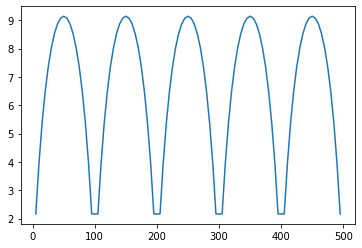

In [7]:
def mat_cov_condi():
    M = C_Z2 - ( (C_Z2_Z1.dot(np.linalg.inv(C_Z1))).dot(C_Z1_Z2) )
    return M

C_Z2sachantZ1 = mat_cov_condi()

position = [i*Delta for i in unknown_indexes]
variance = [C_Z2sachantZ1[i][i] for i in range(95)]

plt.plot(position, variance)

Comme ici, $\Delta = 5$ (m), on obtient logiquement une variance nulle aux points d'observation situés tous les 100m. De la même façon, il paraît logique que la variance augmente lorsqu'on s'éloigne de ces points puisque la position est moins connue loin des sites d'observation.

### 7

## Méthode de Box-Muller

Pour simuler un vecteur gaussien $(Y_{1}, Y_{2})$ de composantes indépendantes, il suffit de considérer deux variables aléatoires uniformes indépendantes $U_{1}$ et $U_{2}$, alors :
\begin{equation}
X_{1} = \sqrt{-2 ln \left(U_{1}\right)} cos \left(2\pi U_{2}\right) \\
X_{2} = \sqrt{-2 ln \left(U_{1}\right)} sin \left(2\pi U_{2}\right)
\end{equation}
sont deux variables aléatoires gaussiennes, indépendantes, d'espérance nulle et d'écart-type 1.

On peut donc simuler autant de paires de composantes gaussiennes indépendantes que l'on veut, ici on veut simuler 95 composantes gaussiennes indépendantes, on va donc simuler 48 paires et enlever une composante à la fin. 

In [8]:
def simul_Y():
    Y = []
    for i in range(48):
        U1 = np.random.random()
        U2 = np.random.random()
        
        X1 = np.sqrt(-2 * np.log(U1))*np.cos(2*np.pi*U2)
        X2 = np.sqrt(-2 * np.log(U1))*np.sin(2*np.pi*U2)
        
        Y.append(X1)
        Y.append(X2)
        
    Y.pop()
    return Y
        

In [9]:
def cholesky(A):
    L = [[0.0] * len(A) for _ in range(len(A))]
    for i, (Ai, Li) in enumerate(zip(A, L)):
        for j, Lj in enumerate(L[:i+1]):
            s = sum(Li[k] * Lj[k] for k in range(j))
            Li[j] = math.sqrt(Ai[i] - s) if (i == j) else \
                      (1.0 / Lj[j] * (Ai[j] - s))
    return L



In [10]:
def nsimul(A, n = 1):
    L1 = cholesky(A)
    L = np.array([np.array(Li) for Li in L1])
    m = Esp_Z2sachantZ1
    
    Liste_res = []
    
    for i in range(n):
        Y = simul_Y()
        res = np.add(m, L.dot(Y))
        Liste_res.append(res)
        
    return Liste_res

l = nsimul(C_Z2sachantZ1, 20)
print(l)
print(len(l[0]))
        

[array([ -1.82607481,  -1.77214149,  -2.4122164 ,  -4.51394567,
        -6.84667418,  -6.54763161,  -6.91716353,  -7.2982798 ,
        -7.50006226,  -6.29394275,  -3.59877497,  -4.73033315,
        -3.07318736,  -3.62439871,  -2.64787723,  -4.49052885,
        -4.73441279,  -4.92838639,  -2.13334611,  -2.61808612,
        -2.10925653,  -3.73153834,  -0.81780747,  -2.18529581,
        -0.0245043 ,  -2.9391809 ,  -2.47395403,  -4.09619372,
        -6.82160707,  -6.2357364 ,  -6.33935523,  -8.65171086,
        -9.55399616,  -9.61804926,  -9.23598436, -10.2943951 ,
       -11.39065033,  -9.56486094, -10.97967067, -10.16954722,
       -13.01791458, -13.32838923, -15.34069989, -15.80259495,
       -12.79693816, -11.59502559,  -7.68681047,  -6.67470832,
        -5.45398017,  -6.5966791 ,  -8.47196702,  -6.42729072,
        -7.22099833,  -5.31383668,  -5.08540707,  -3.29225207,
        -2.35374158,  -3.86728722,  -5.81181063,  -7.93589928,
        -8.83671403,  -8.9318196 ,  -7.475869  ,  -8.0

In [13]:
def longueur(Z, Delta):
    length = 0
    for i in range(len(Z)-1):
        length += math.sqrt(Delta**2+(Z[i+1]-Z[i])**2)
    return length

In [14]:
def compare(nbsimul):
    LengthEsp = longueur(Esp_Z2sachantZ1, Delta)
    l = nsimul(C_Z2sachantZ1, nbsimul)
    EcartType = 0
    Length = 0
    for simul in l:
        EcartType += (longueur(simul, Delta)-LengthEsp)**2
        Length +=  longueur(simul, Delta)
    Length = Length/nbsimul
    EcartType = EcartType/nbsimul
    EcartRelatif = (Length - LengthEsp)/LengthEsp
    print("Longueur simulation = ", Length)
    print("Longueur espérance = ", LengthEsp)
    print("Ecart type = ", EcartType)
    print("Ecart relatif = ", EcartRelatif)

compare(100)

Longueur simulation =  491.3539481100065
Longueur espérance =  471.390923999467
Ecart type =  406.2708072464762
Ecart relatif =  0.04234919064874076
